In [81]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# # Auctions parameters
# n_users = 100       # number of users each day
# n_advertisers = 4  # number of advertisers other than us
# B = 5              # budget
# n_slots = 1        # number of slots
# available_bids = np.linspace(0,1,80) # bid discretization

In [3]:
# Auctions Environment
class GeneralFirstPriceAuction:
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots = n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-self.n_slots:]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)

    def round(self, bids):
        winners, values = self.get_winners(bids)
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [4]:
# Auctions Agent

# Regret minimizer for multiplicative pacing
class RegretMinimizer_Hedge:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

# Multiplicative pacing agent non-trivial
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = RegretMinimizer_Hedge(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

# multiplicative pacing agent truthful
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update(self, f_t, c_t, m_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

# UCB
class UCBBiddingAgent:
    def __init__(self, bids_set, budget, valuation, T):
      self.bids_set = bids_set
      self.budget = budget
      self.valuation = valuation
      self.T = T
      self.rho = self.budget/self.T
      self.t = 0
      self.bids_history = []
      self.f = []
      self.c = []

    def bid(self):
        if self.budget < 1:
          self.bids_history.append(0)
          return 0
        elif self.t<len(self.bids_set):
          self.bids_history.append(self.bids_set[self.t])
          return self.bids_set[self.t]
        else:
          f_opti, c_opti, sup, best_bid = 0, 0, 0, 0
          for bid in self.bids_set:
            f_t = 0
            c_t = 0
            N = 0
            for i in range(self.t):
              if (self.bids_history[i] == bid):
                f_t += self.f[i]
                c_t += self.c[i]
                N += 1
            f_t = f_t/N
            c_t = c_t/N
            f_ucb = f_t + np.sqrt(2*math.log(self.T)/N)
            c_lcb = c_t - np.sqrt(2*math.log(self.T)/N)
            if (c_lcb<=self.rho and f_ucb>sup):
              sup = f_ucb
              f_opti = f_t
              c_opti = c_t
              best_bid = bid
          self.bids_history.append(best_bid)
          return best_bid

    def update(self, f_t, c_t, m_t):
      self.f.append(f_t)
      self.c.append(c_t)
      self.budget -= c_t
      self.t += 1

In [82]:
# Play against each other
def play(
    n_users = 100,      # number of users
    # K_bids = 80,        # number of available bids for discretization
    B = 5,              # budget
    # rho = B/n_users,    # budget per round
    n_slots = 1,        # number of slots
    available_bids = np.linspace(0,1,80), # bid discretization
    n = 12
):
    auctionsEnv = GeneralFirstPriceAuction(np.ones(n), n_slots) # assuming all advertisers have the same CTR=1 ie their ads are clicked with probability 1
    eta = 1/np.sqrt(n_users)

    values = [0.8, 0.8, 0,8, 0,8]
    agents = []

    utilities = np.zeros((n_users,n))
    bids = np.zeros((n_users,n))
    payments = np.zeros((n_users,n))
    winning_bids = np.zeros((n_users))
    winning_agents = np.zeros((3))
    for i in range(int(n/3)):
        agents.append(MultiplicativePacingAgent(values[i], B, n_users, eta))
    for i in range(int(n/3)):
        agents.append(FFMultiplicativePacingAgent(available_bids, values[i], B, n_users, eta))
    for i in range(int(n/3)):
        agents.append(UCBBiddingAgent(available_bids, B, values[i], n_users))
    for u in range(n_users):
        # AUCTIONS ROUND
        bid_t = [agent.bid() for agent in agents]
        winners, payments_per_click = auctionsEnv.round(bid_t)
        fs_t, cs_t = np.zeros(n), np.zeros(n)
        for i, winner in enumerate(winners):
            cs_t[winner] = payments_per_click[i]
            fs_t[winner] = values[i//4]-cs_t[winner]
        m_t = bid_t[winners[-1]]
        # update auctions agent
        for i, agent in enumerate(agents):
            agent.update(fs_t[i], cs_t[i], m_t)
        # update reward sequence
        utilities[u] = fs_t
        payments[u] = cs_t
        bids[u] = bid_t
        winning_bids[u] = m_t
        indices = np.atleast_1d(np.where(bid_t == m_t)[0])
        if any(0 <= x < int(n/3) for x in indices):
          winning_agents[0] += 1
        elif any(int(n/3) <= x < int(n/3)*2 for x in indices):
          winning_agents[1] += 1
        elif any(int(n/3)*2 <= x < int(n/3)*3 for x in indices):
          winning_agents[2] += 1
    return (utilities, bids, payments, winning_bids, winning_agents)

In [6]:
def plot_time_player(ax, array, title, label, n):
    for i in range(n):
        ax.plot(array[:, i], label=f'Player {i+1}')

    ax.set_xlabel('Time (users)')
    ax.set_ylabel(title)
    ax.set_title(label)
    ax.legend()


In [7]:
# Plot the utilities over time for each of the players
def plot_utilities(utilities, n, ax):
    plot_time_player(ax, utilities, 'Utilities', 'Utilities over time for each player', n)

In [8]:
# Plot the utilities over time for each of the players
def plot_bids(bids, n, ax):
    plot_time_player(ax, bids, 'Bids', 'Bids over time for each player', n)

In [9]:
# Plot the utilities over time for each of the players
def plot_payments(payments, n, ax):
    plot_time_player(ax, payments, 'Payments', 'Payments over time for each player', n)

In [10]:
def plot_winningbid(winning_bids, ax):
    """
    Plots the winning bids over time on a given axis.

    Parameters:
    - ax: The axis to plot on.
    - winning_bids: 1D numpy array where each element represents the winning bid at a time point.
    """
    ax.plot(winning_bids, label="Winning bid")
    ax.set_xlabel('Time (users)')
    ax.set_ylabel('Bids')
    ax.set_title('Winning bids over time')
    ax.legend()

In [111]:
# Function to plot all the subplots in one figure
def plot_all(utilities, bids, payments, winning_bids, winning_agents, n):
    fig, axes = plt.subplots(1, 1, figsize=(20, 5))
    fig.suptitle('Win rates', fontsize=25)
    categories = ['Multiplicative Pacing Agent', 'FF Multiplicative Pacing Agent', 'UCB Bidding Agent']
    plt.bar(categories, winning_agents)
    plt.ylabel('Number of wins')
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    plot_utilities(utilities, n, axes[0])
    plot_bids(bids, n, axes[1])
    plot_payments(payments, n, axes[2])
    plot_winningbid(winning_bids, axes[3])
    fig.suptitle('Combined results', fontsize=25)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plot_utilities(utilities[:, :int(n/3)], int(n/3), axes[0])
    plot_bids(bids[:, :int(n/3)], int(n/3), axes[1])
    plot_payments(payments[:, :int(n/3)], int(n/3), axes[2])
    fig.suptitle('Multiplicative Pacing Agent', fontsize=25)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plot_utilities(utilities[:, int(n/3):int(n/3)*2], int(n/3), axes[0])
    plot_bids(bids[:, int(n/3):int(n/3)*2], int(n/3), axes[1])
    plot_payments(payments[:, int(n/3):int(n/3)*2], int(n/3), axes[2])
    fig.suptitle('FF Multiplicative Pacing Agent', fontsize=25)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plot_utilities(utilities[:, int(n/3)*2:int(n/3)*3], int(n/3), axes[0])
    plot_bids(bids[:, int(n/3)*2:int(n/3)*3], int(n/3), axes[1])
    plot_payments(payments[:, int(n/3)*2:int(n/3)*3], int(n/3), axes[2])
    fig.suptitle('UCB Bidding Agent', fontsize=25)
    plt.tight_layout()
    plt.show()

<ipython-input-82-e836db1caf13>:45: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  indices = np.atleast_1d(np.where(bid_t == m_t)[0])


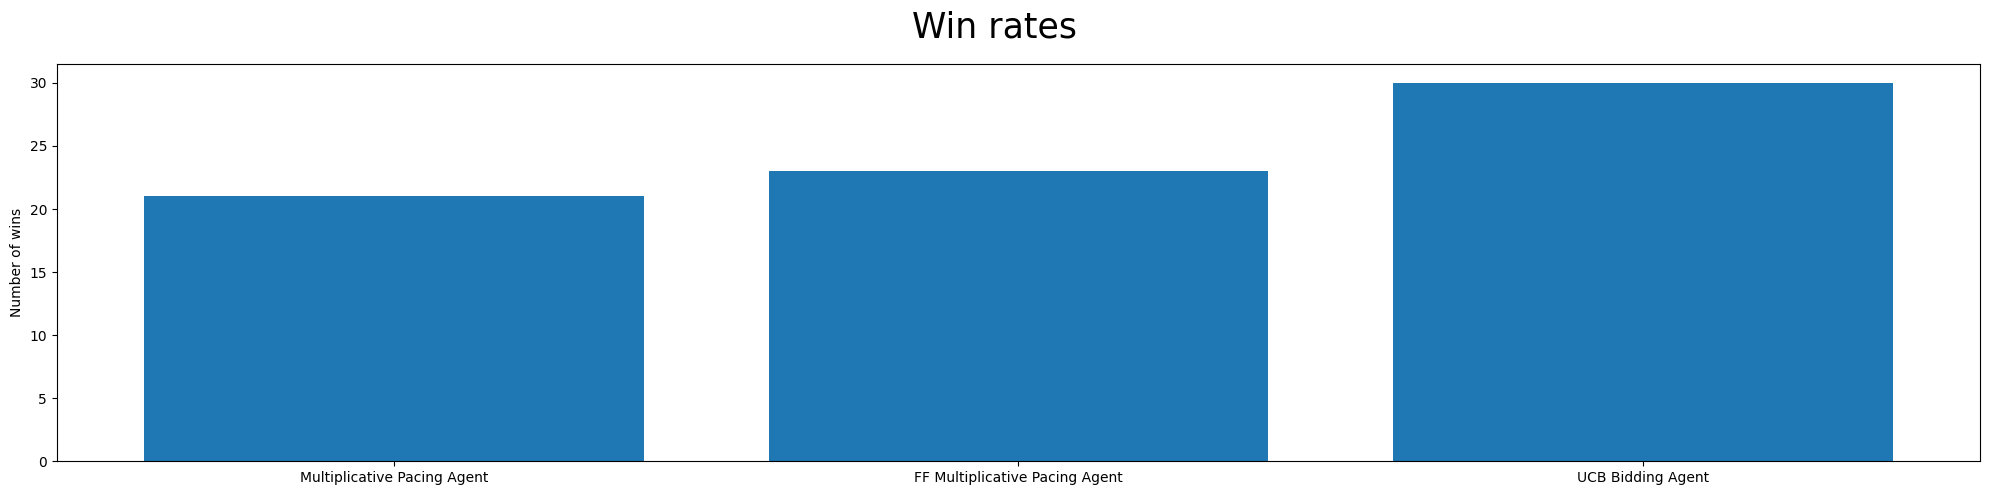

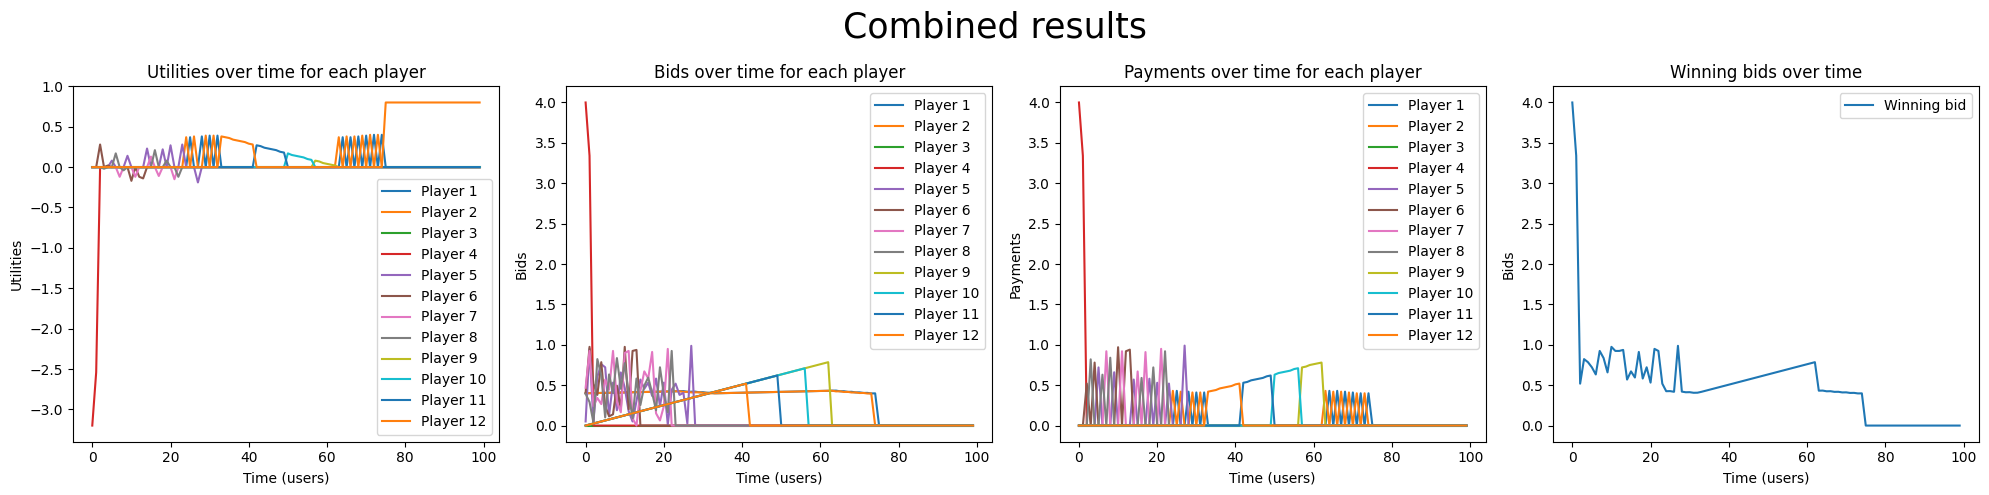

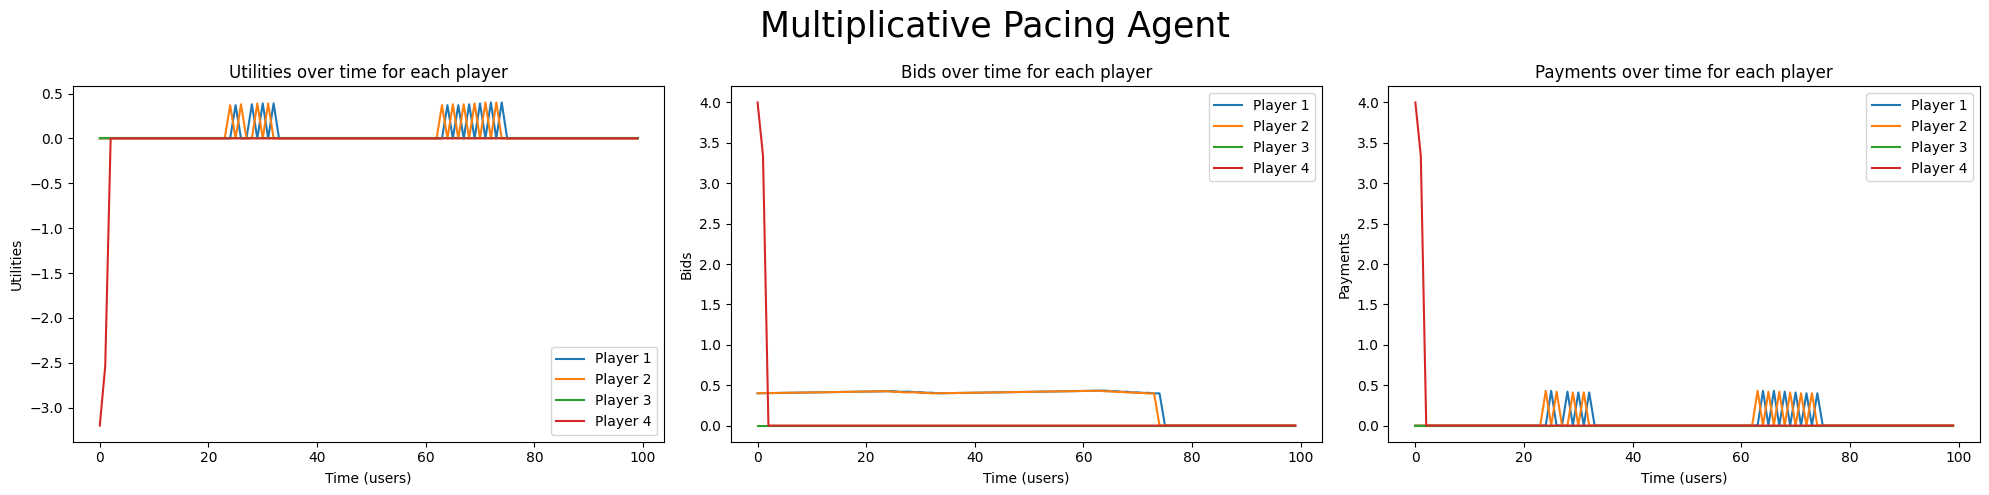

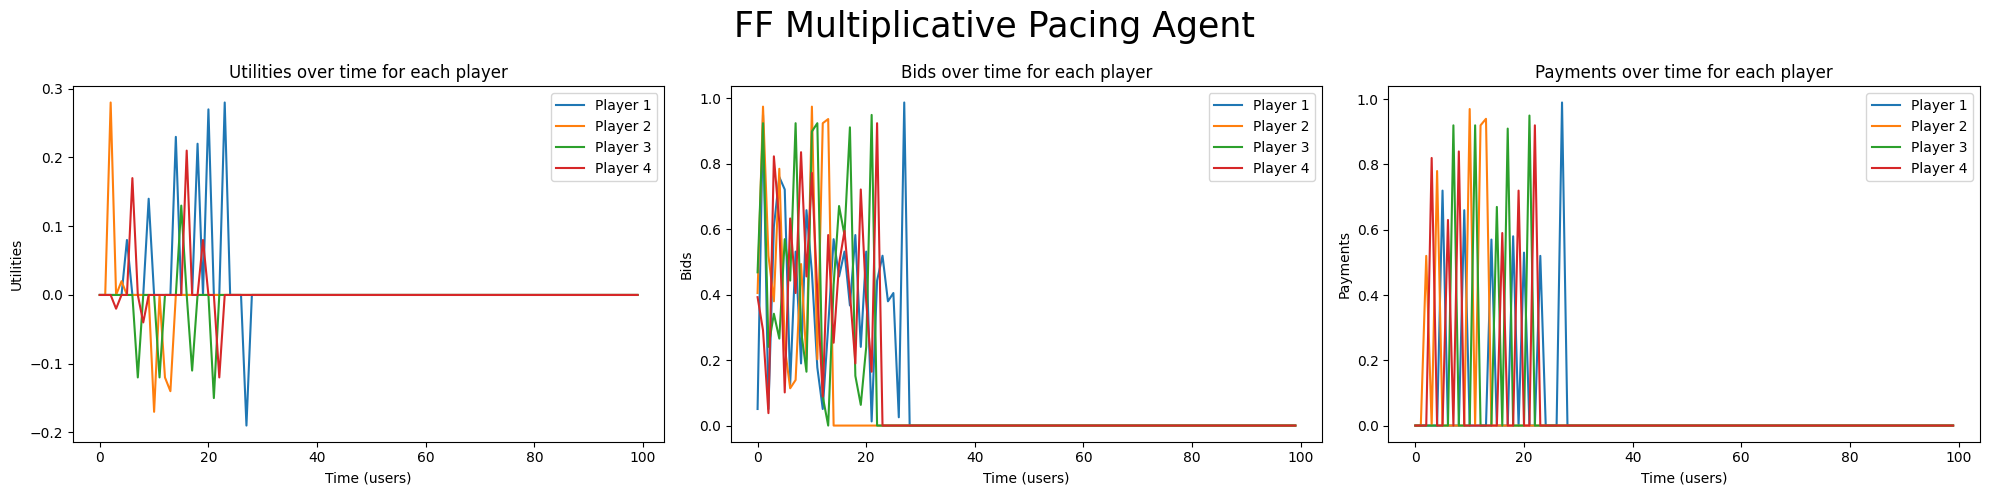

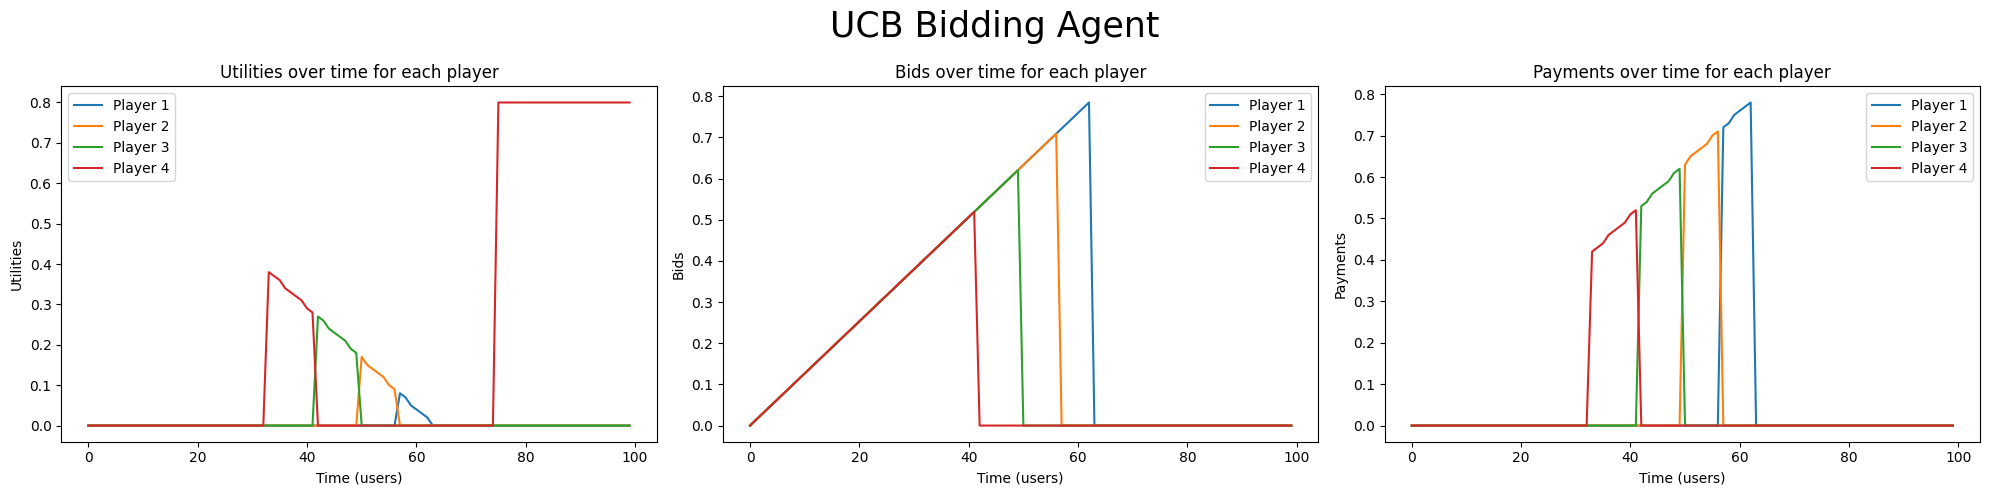

In [112]:
# Auctions parameters
n_users = 100       # number of users each day
n_advertisers = 4  # number of advertisers other than us
B = 5              # budget
n_slots = 1        # number of slots
available_bids = np.linspace(0,1,80) # bid discretization
n = 3*4
utilities, bids, payments, winning_bids, winning_agents = play(n_users, B, n_slots, available_bids, n)
plot_all(utilities, bids, payments, winning_bids, winning_agents, n)

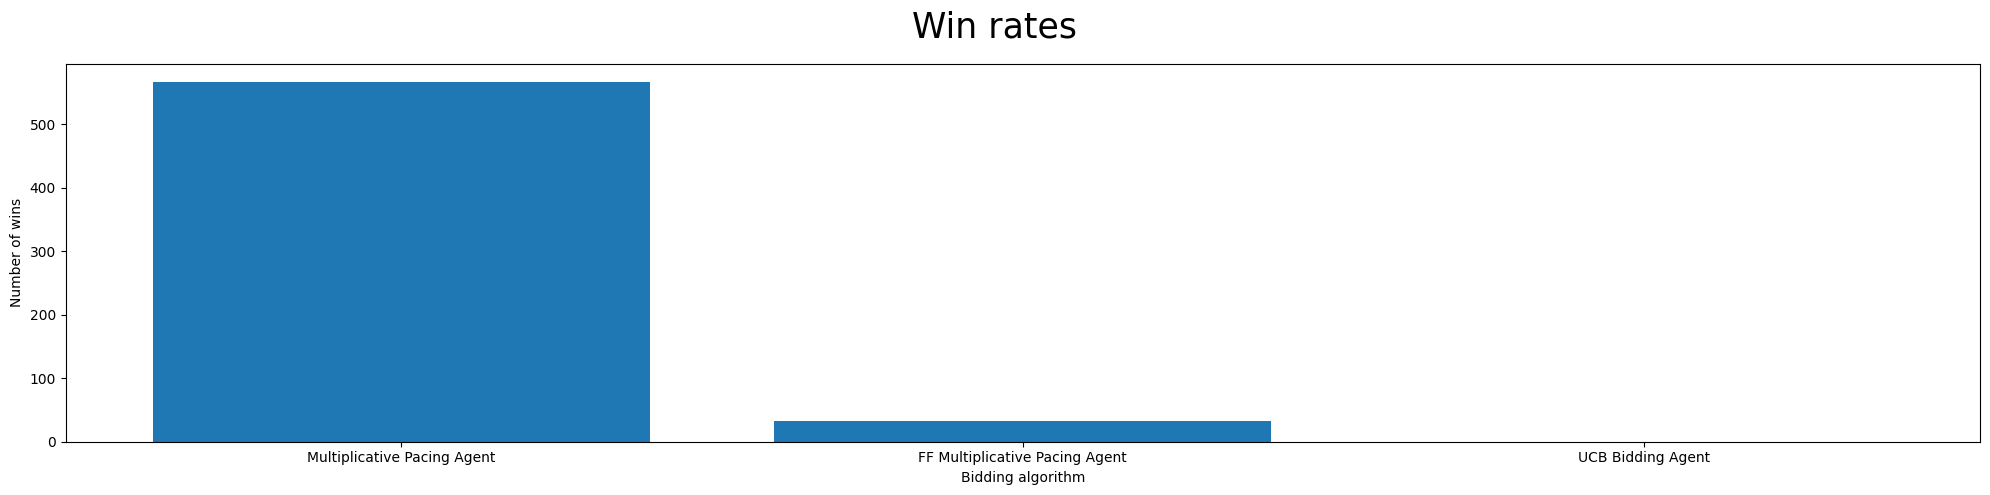

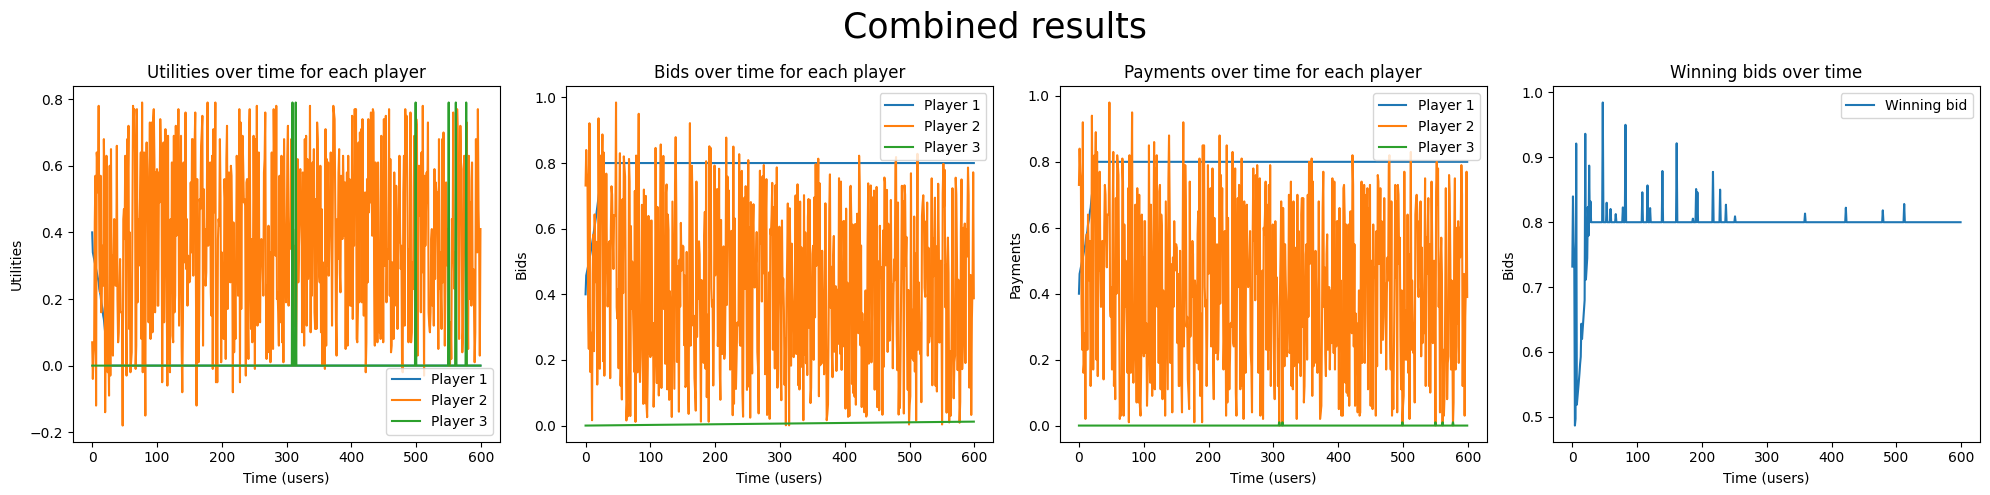

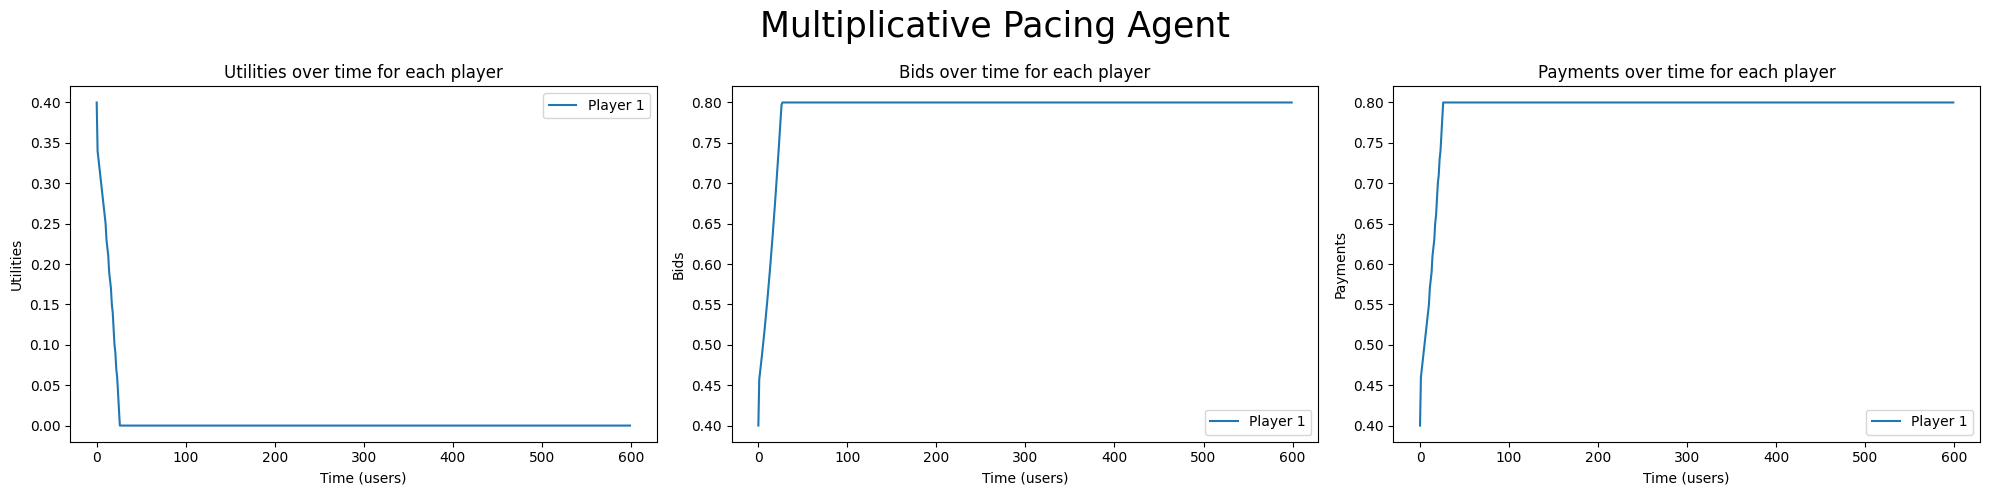

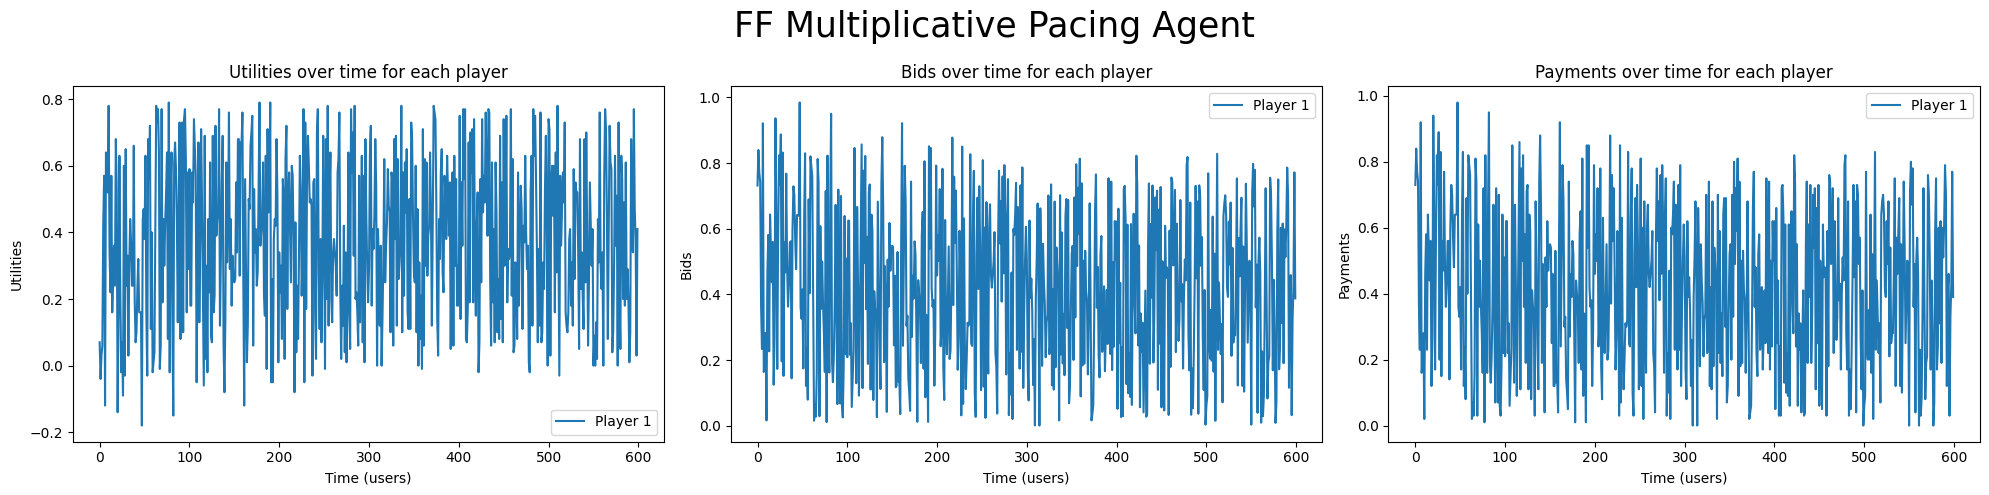

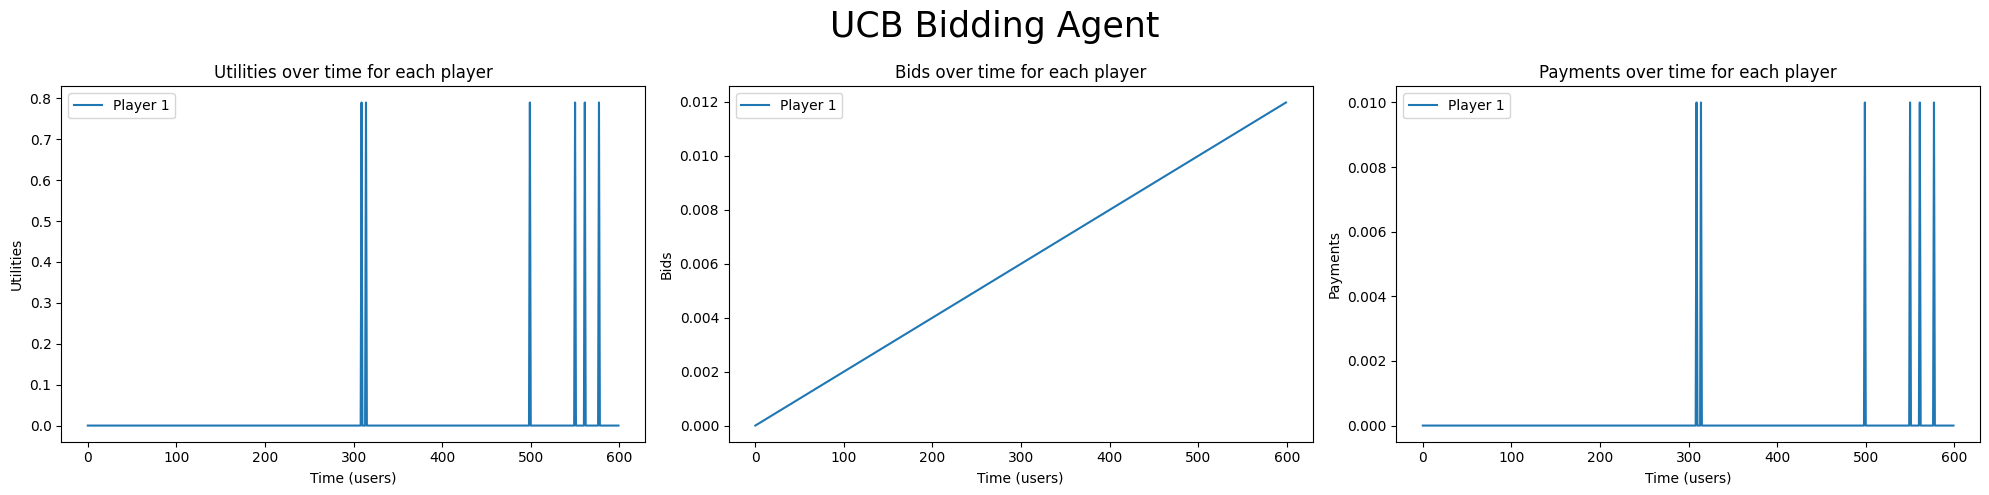

In [107]:
utilities, bids, payments, winning_bids, winning_agents = play(600, 800, 2, np.linspace(0,1,50000), 3)
plot_all(utilities, bids, payments, winning_bids, winning_agents, 3)

<ipython-input-82-e836db1caf13>:45: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  indices = np.atleast_1d(np.where(bid_t == m_t)[0])


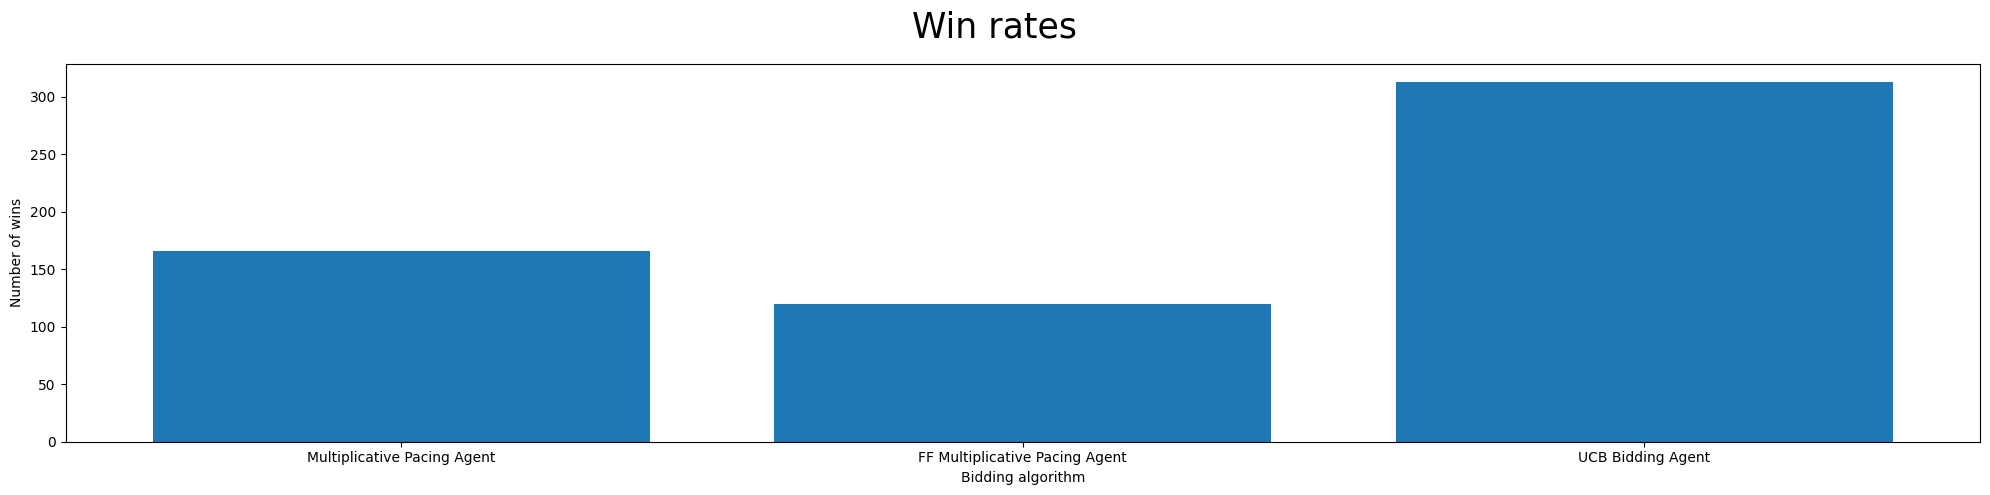

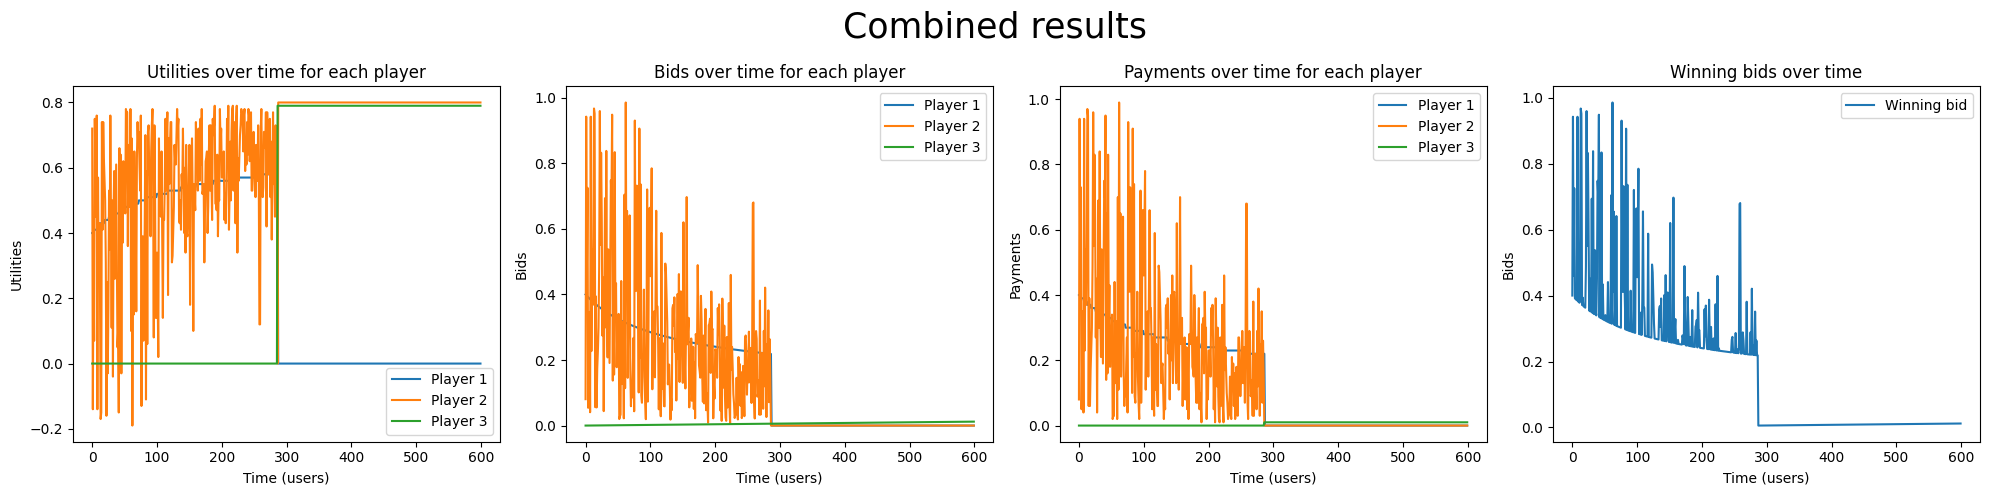

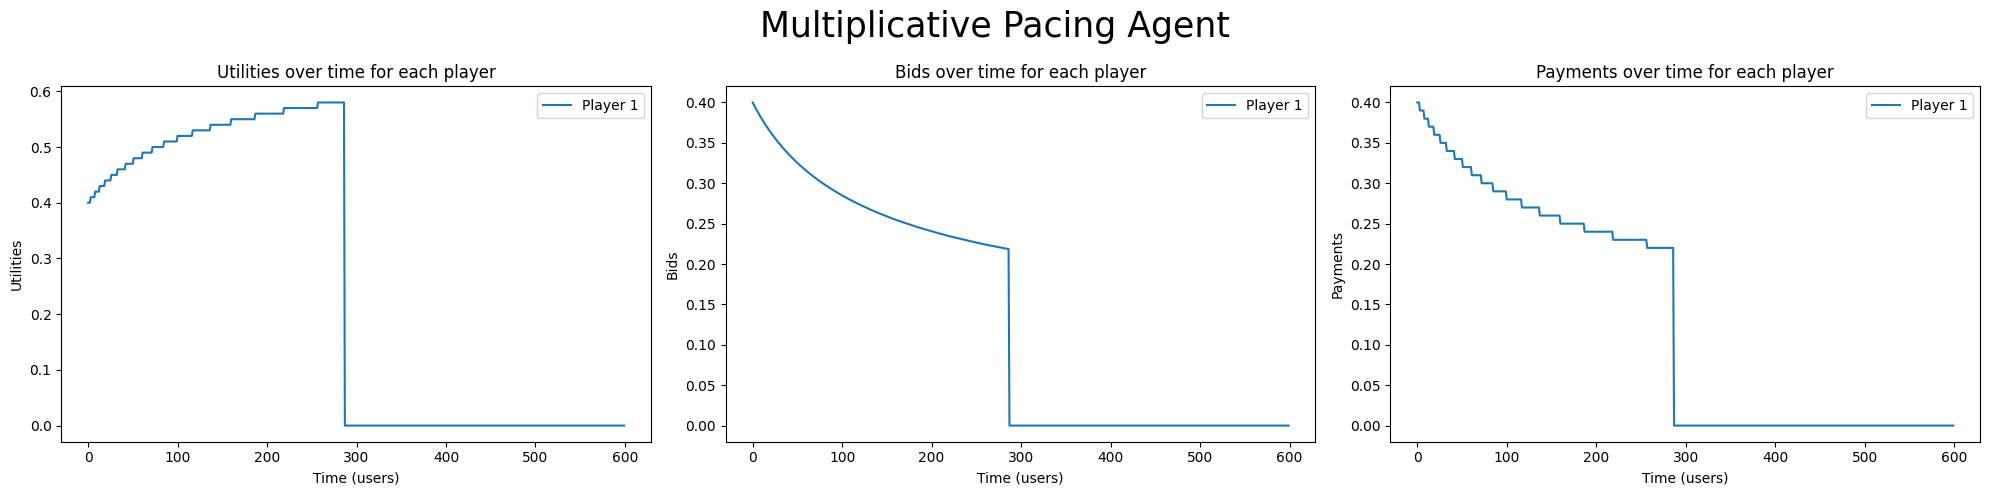

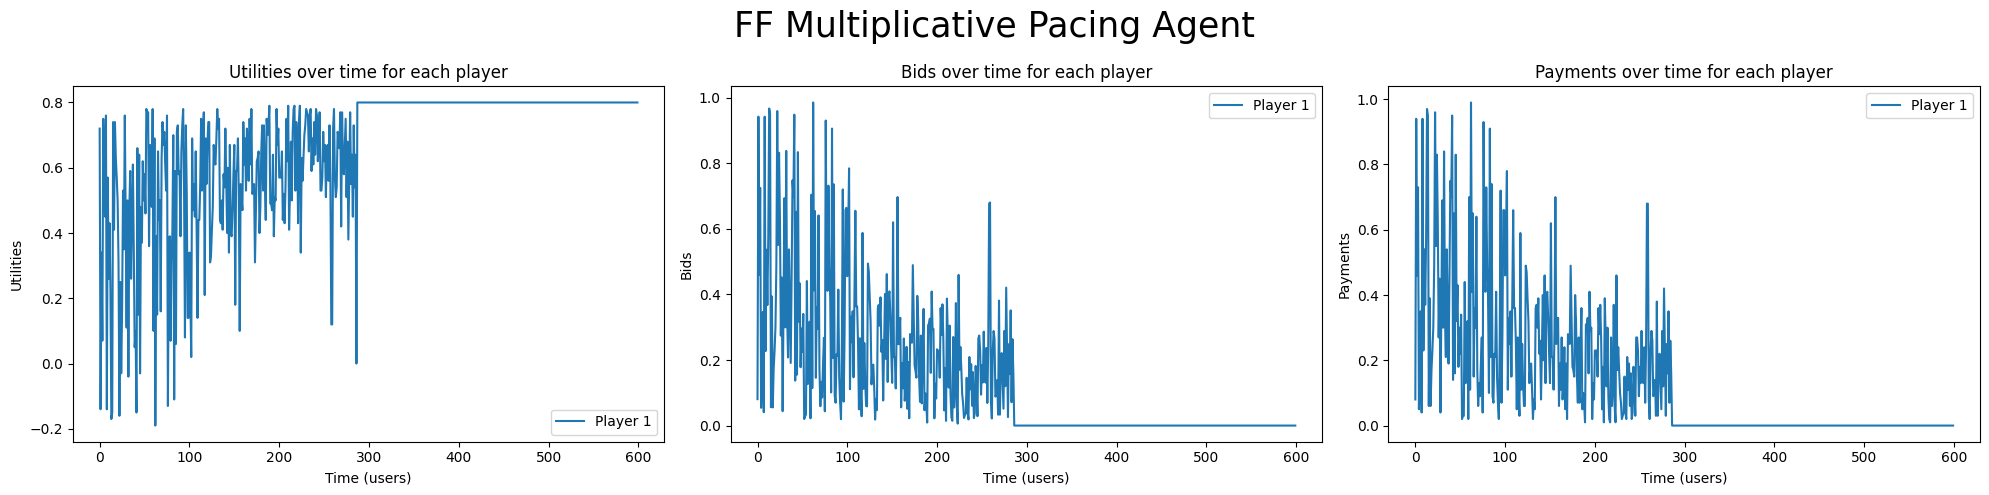

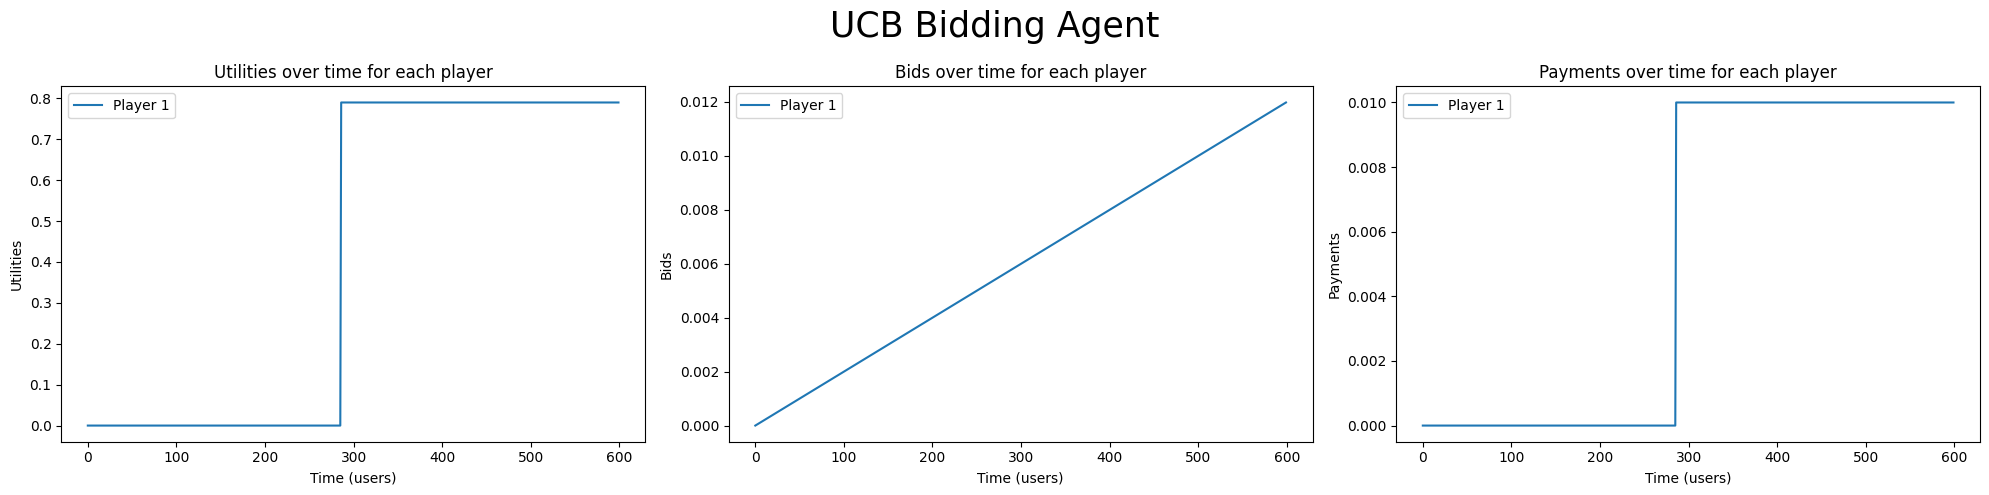

In [108]:
utilities, bids, payments, winning_bids, winning_agents = play(600, 80, 2, np.linspace(0,1,50000),3)
plot_all(utilities, bids, payments, winning_bids, winning_agents, 3)

<ipython-input-82-e836db1caf13>:45: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  indices = np.atleast_1d(np.where(bid_t == m_t)[0])


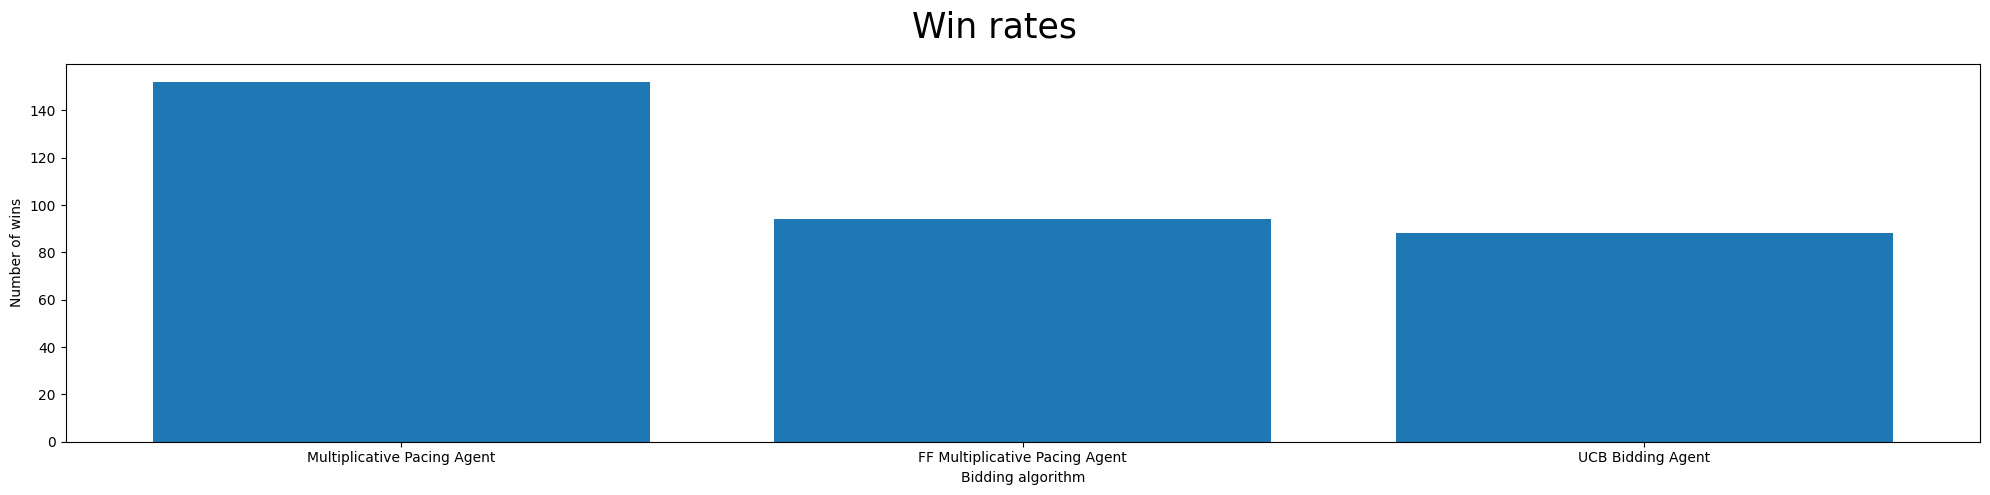

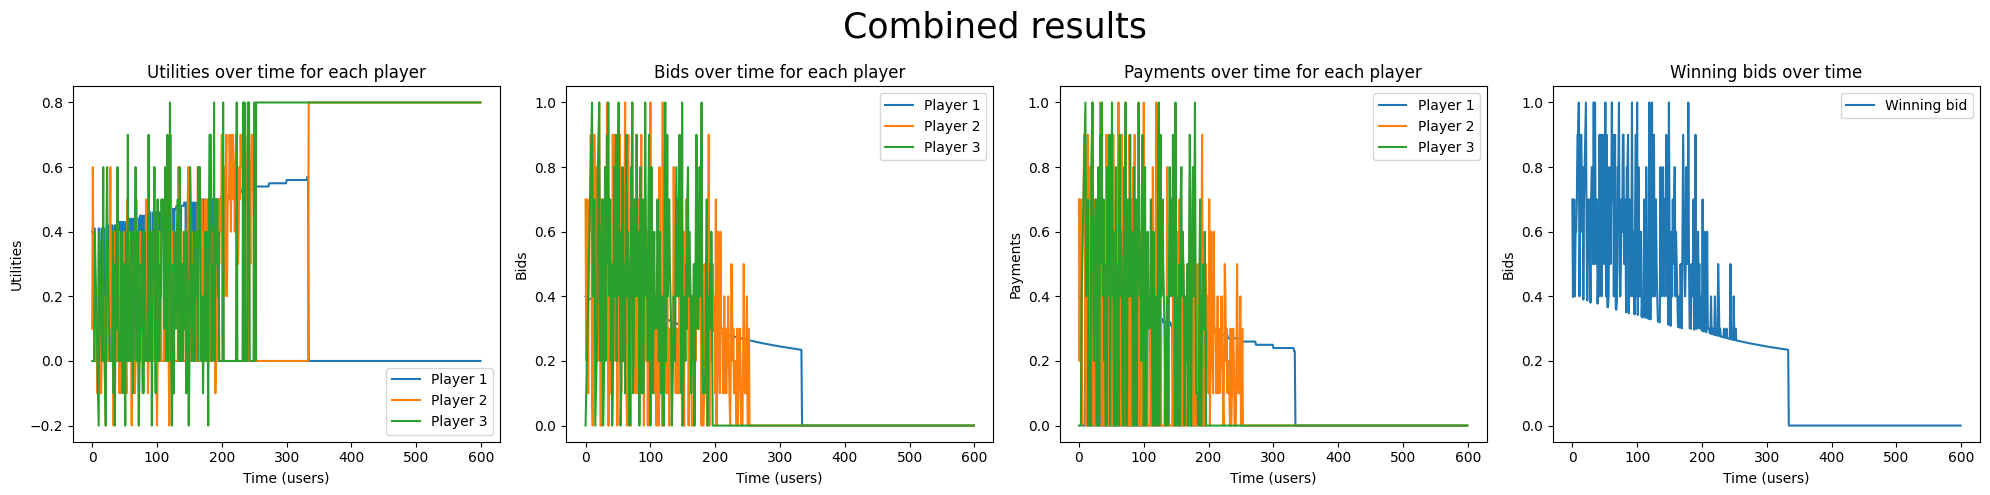

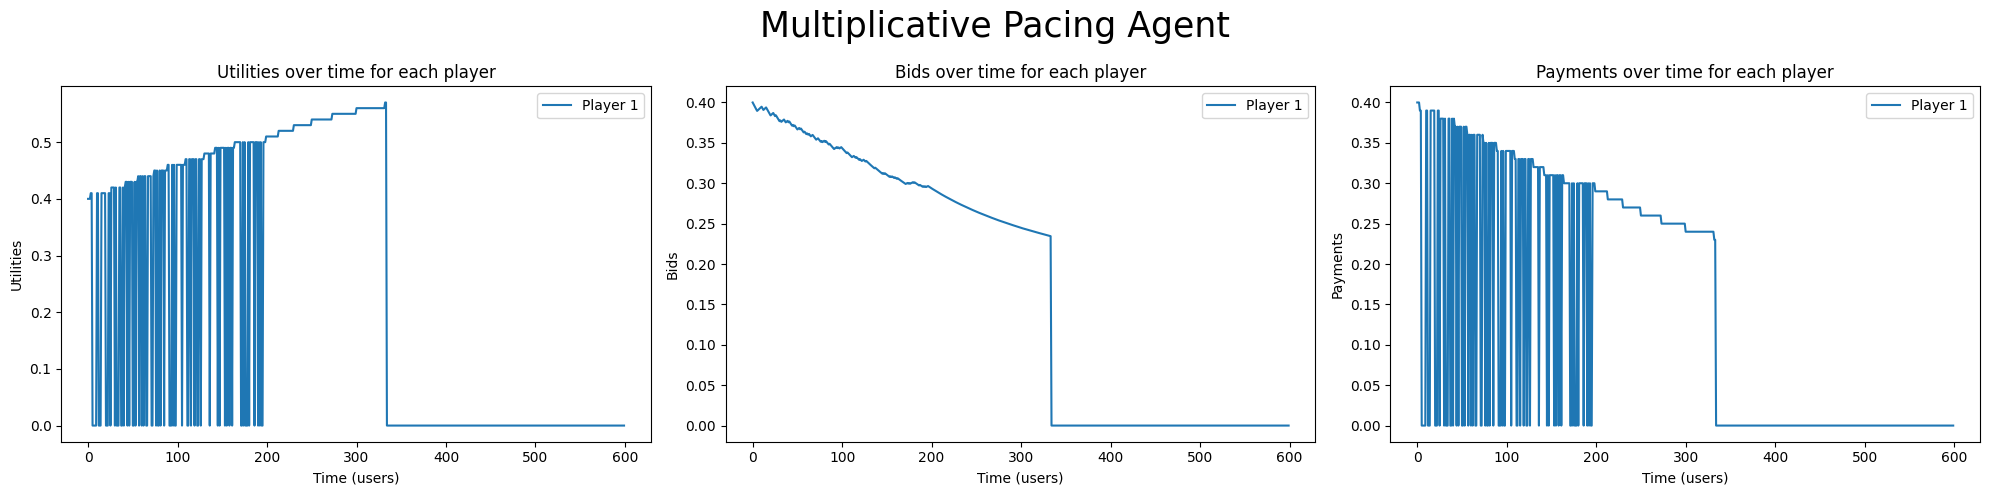

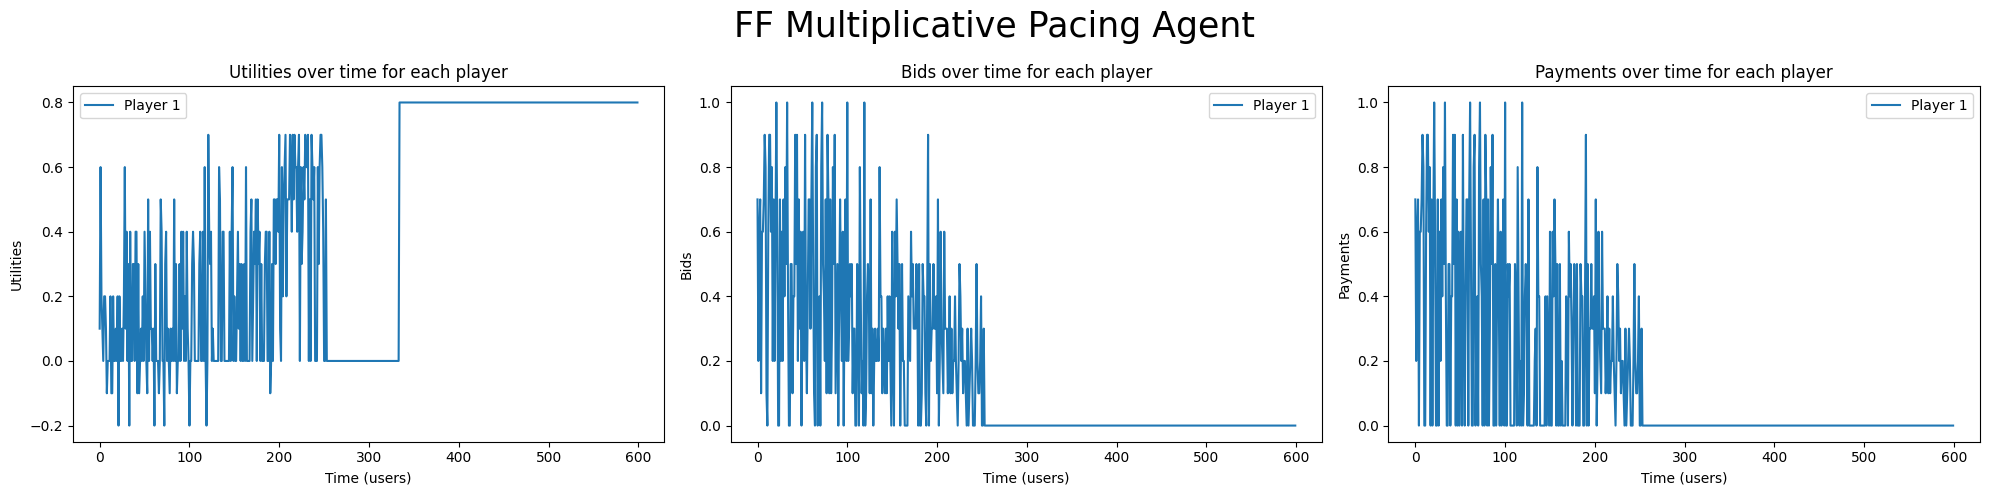

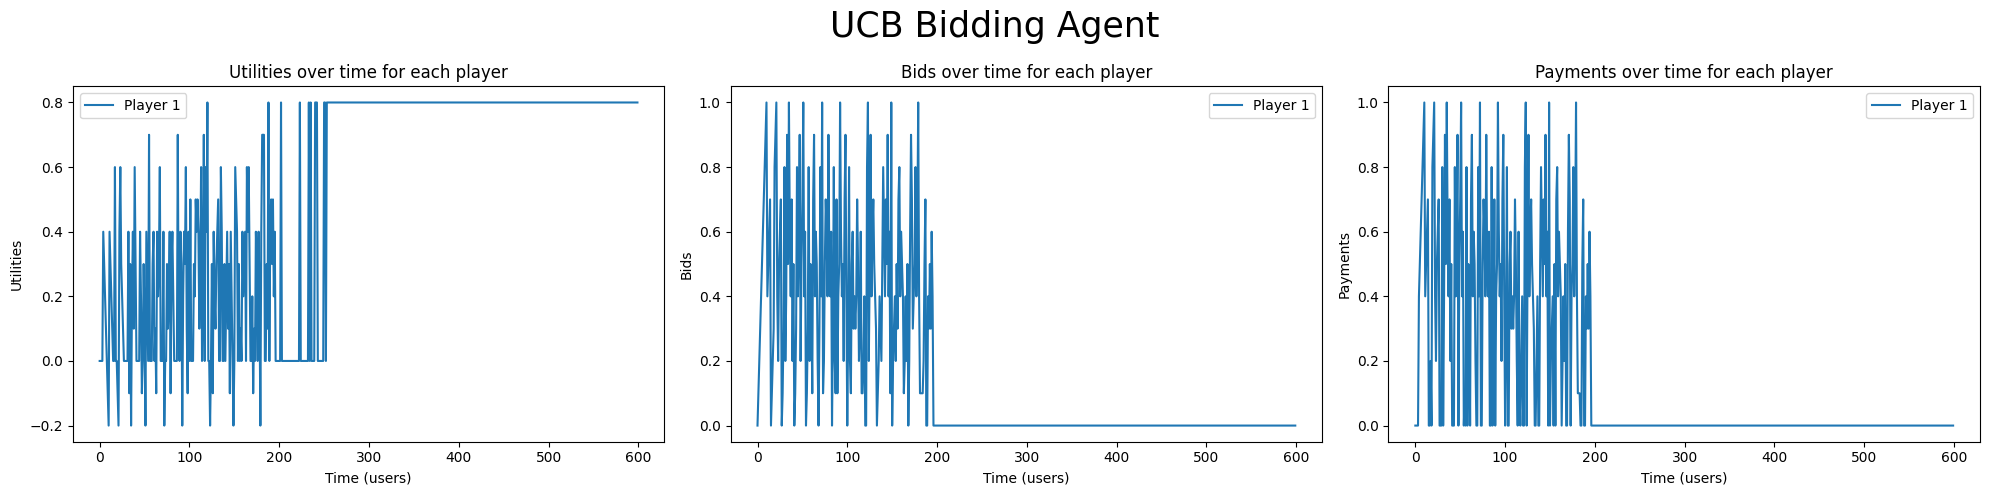

In [109]:
utilities, bids, payments, winning_bids, winning_agents = play(600, 80, 2, np.linspace(0,1,11),3)
plot_all(utilities, bids, payments, winning_bids, winning_agents, 3)

<ipython-input-82-e836db1caf13>:45: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  indices = np.atleast_1d(np.where(bid_t == m_t)[0])


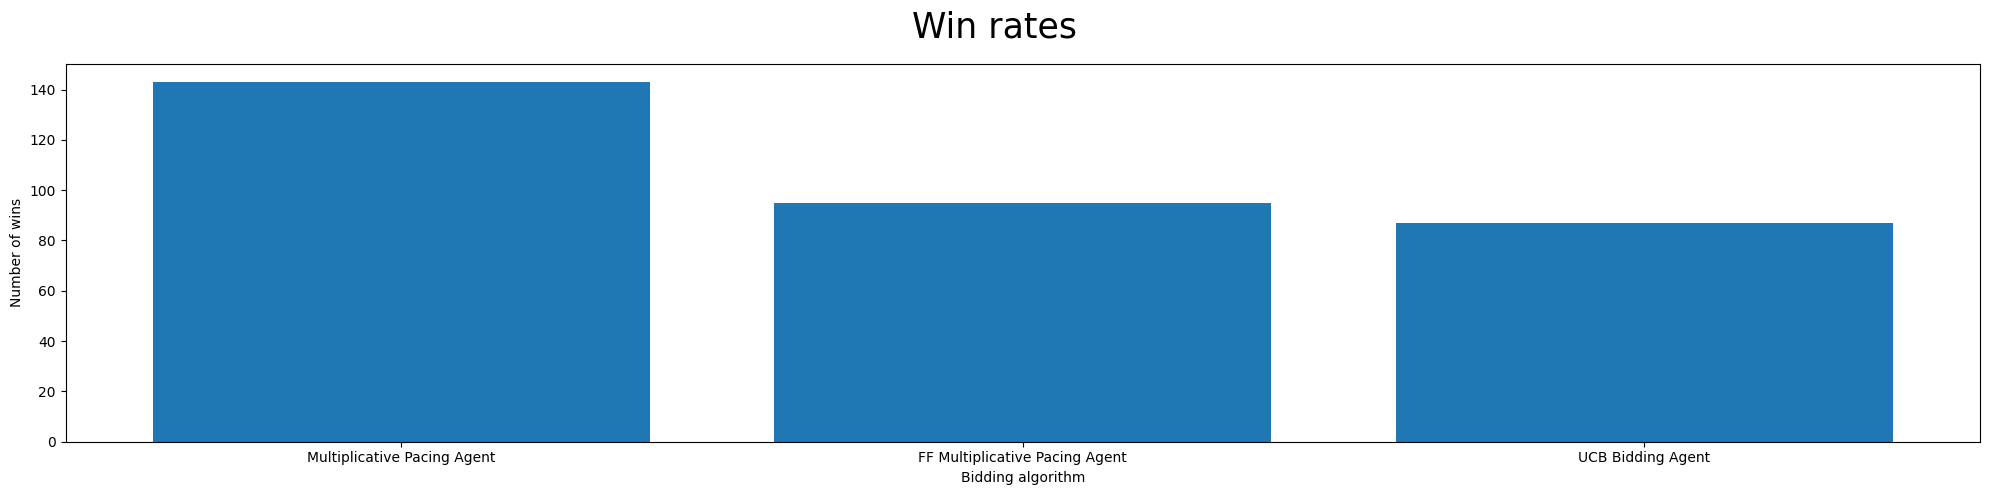

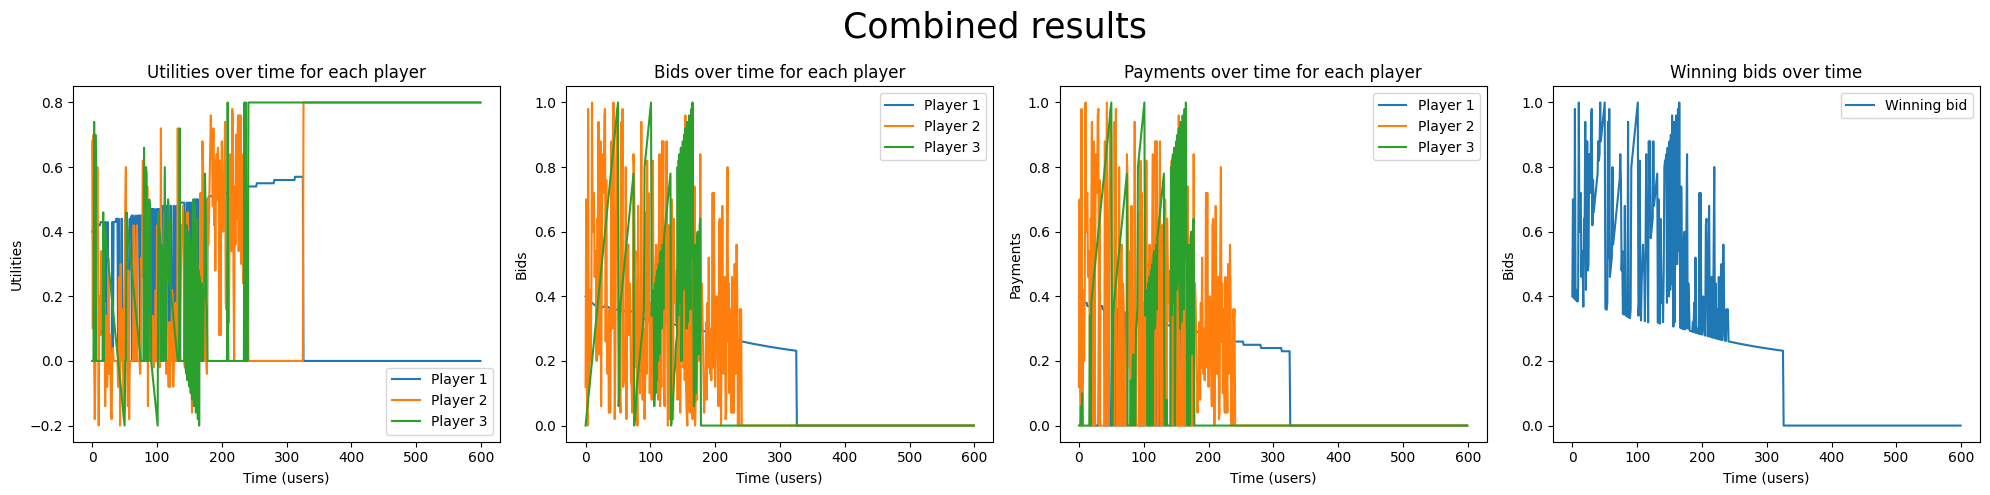

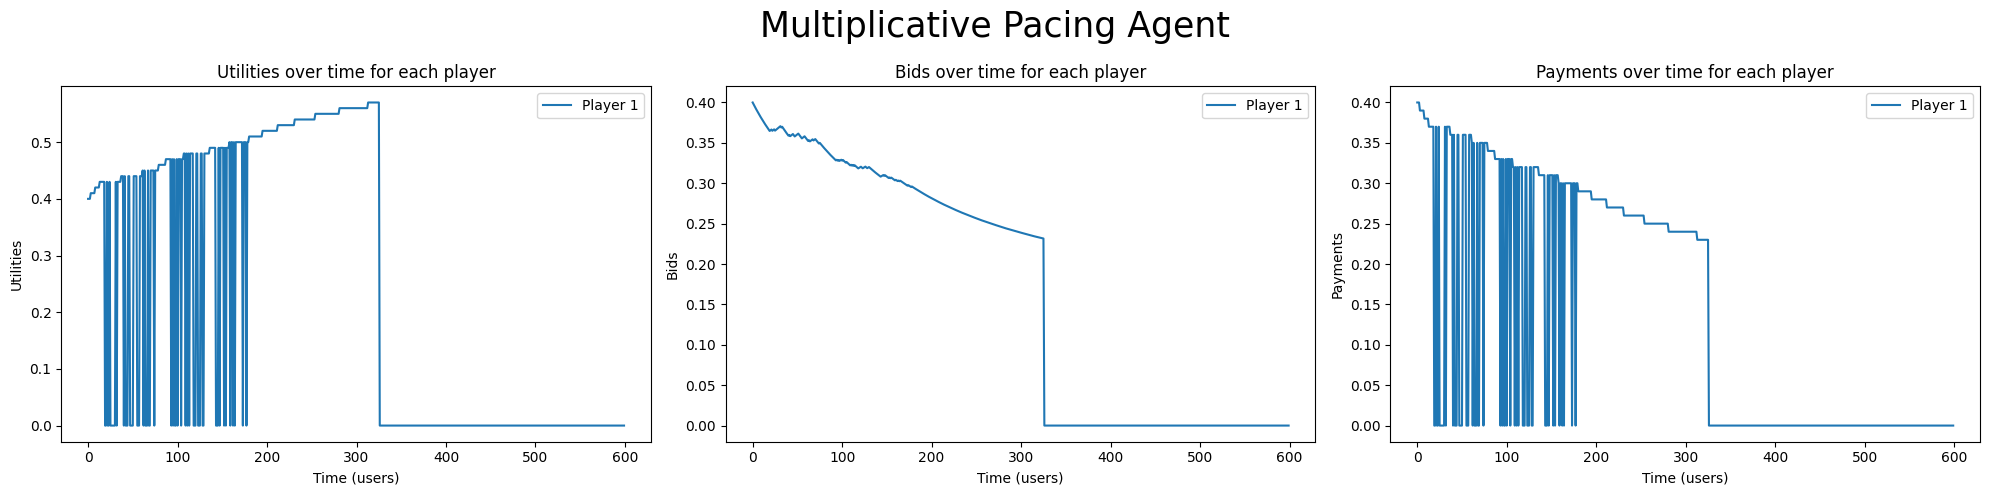

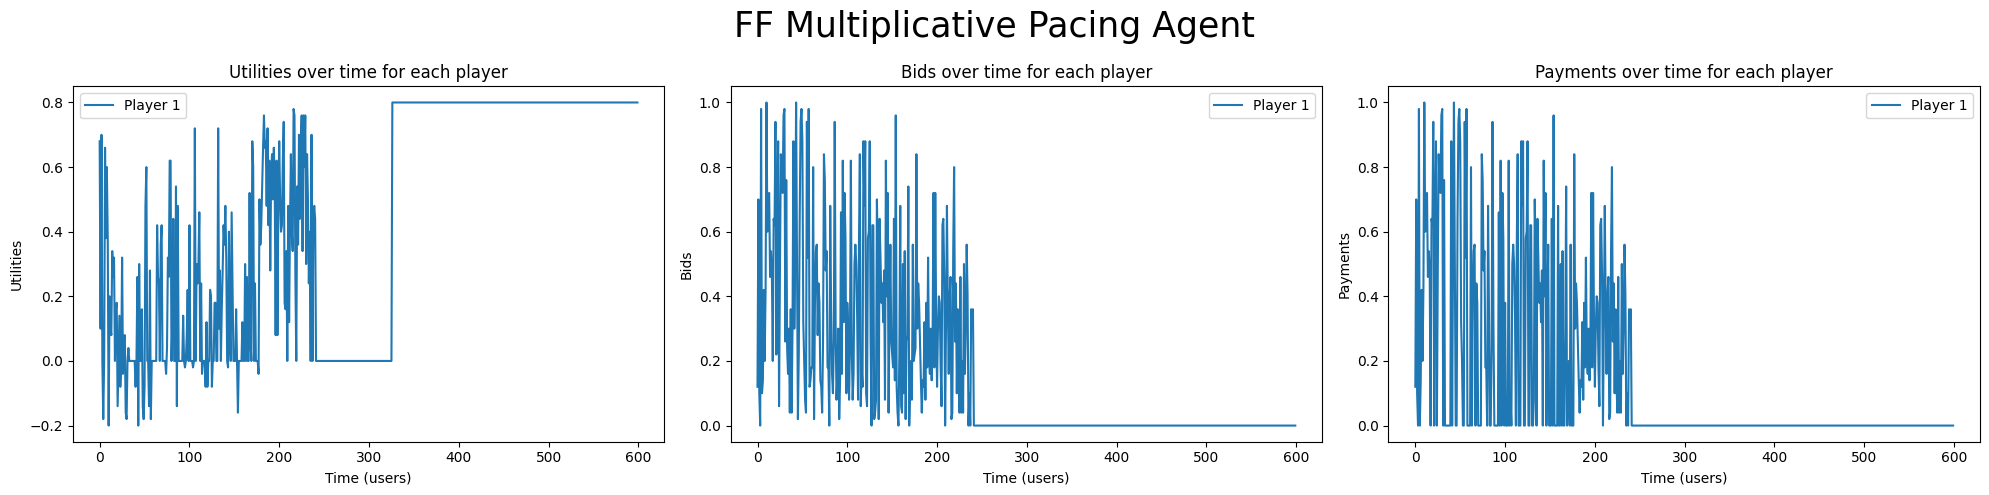

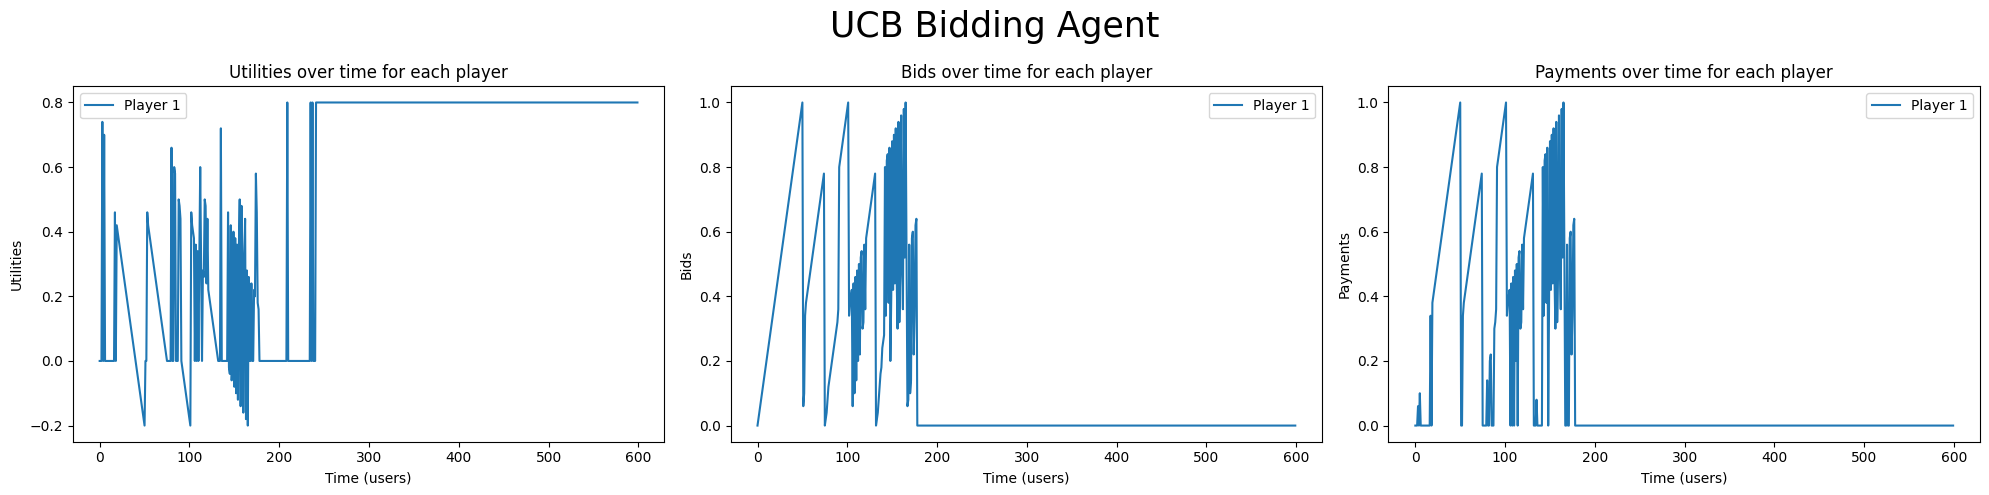

In [110]:
utilities, bids, payments, winning_bids, winning_agents = play(600, 80, 2, np.linspace(0,1,51),3)
plot_all(utilities, bids, payments, winning_bids, winning_agents, 3)